In [31]:
%pip install -q tensorflow scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Bidirectional, Add, Input, Attention, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

## Step 1: Data Splitting

In [33]:
# Parameters for LSTM workflow
CSV_PATH = 'btc_processed.csv' 
WINDOW_SIZE = 14  # sequence length
TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42
TARGET_HORIZON = 7  # predict direction over N days

# Advanced settings
USE_ATTENTION = True  # add attention mechanism
USE_RESIDUAL = True   # residual connections in attention block
USE_FOCAL_LOSS = True # focal loss for class imbalance

df = pd.read_csv(CSV_PATH)

print(f'Window size: {WINDOW_SIZE}')
print(f'Target horizon: {TARGET_HORIZON} day(s)')
print(f'Attention={USE_ATTENTION}, Residual={USE_RESIDUAL}, FocalLoss={USE_FOCAL_LOSS}')

Window size: 14
Target horizon: 7 day(s)
Attention=True, Residual=True, FocalLoss=True


In [34]:
# X_all = df[[
#     # Raw prices
#     # "open", "high", "low", "close", "volume",
    
#     # Lagged returns / spreads
#     "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    
#     # Technical indicators
#     "rsi_7", "rsi_14", "cci_7", "cci_14",
#     "sma_50", "ema_50", "sma_100", "ema_100",
#     "macd", "bollinger", "TrueRange", "atr_7", "atr_14",
    
#     # Log features (optional, may remove if redundant)
#     "log_open", "log_high", "log_low", "log_close", "log_volume",
#     "log_MA_7", "log_MA_30"
# ]].values.astype(float)

# X_all = df[[
#     # --- SAFE FEATURES (Relative/Oscillators) ---
#     "Daily_Return", 
#     "High_Low_Spread", 
#     "Close_Open_Spread",
    
#     "rsi_7", "rsi_14", 
#     "cci_7", "cci_14",
#     "macd",
# ]].copy()

# # Fix ATR/TrueRange to be stationary
# X_all['atr_7_pct'] = df['atr_7'] / df['close']
# X_all['atr_14_pct'] = df['atr_14'] / df['close']
# X_all['truerange_pct'] = df['TrueRange'] / df['close']

# # Fix Moving Averages (Distance from MA)
# # Instead of raw "50,000", use "Price is 5% above MA"
# X_all['dist_sma_50'] = (df['close'] - df['sma_50']) / df['sma_50']
# X_all['dist_ema_50'] = (df['close'] - df['ema_50']) / df['ema_50']

# Now select only the final columns
features = [
    "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    "rsi_7", "rsi_14", "cci_7", "cci_14", "macd",
    "atr_7_pct", "atr_14_pct", "truerange_pct",
    "dist_sma_50", "dist_ema_50"
]
X_all = df[final_features].values.astype(float)
    

y_all = df['Target']

y_all = df['Target'].values.astype(int)

print(f'\nData shape: {X_all.shape[0]} samples × {X_all.shape[1]} features')


Data shape: 3377 samples × 13 features


In [35]:
# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3363, 14, 13) y (3363,)


In [36]:
# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2690 Test samples: 673


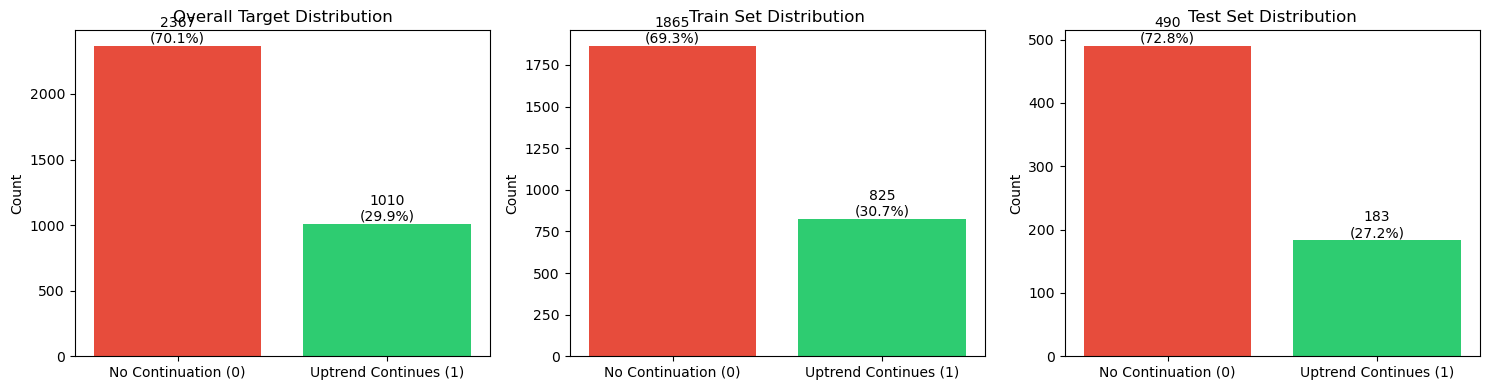


Class balance ratio (Uptrend Continues/No Continuation): 0.427


In [37]:
# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

- Normalization

In [38]:
# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Final tensors for LSTM
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM):', X_train_3d.shape, X_test_3d.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM): (2690, 14, 13) (673, 14, 13)


## Step 2: Model Training

In [39]:
# LSTM model with attention and focal loss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Add, LayerNormalization, MultiHeadAttention, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow.keras.backend as K

# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

def build_lstm_model(window_size, n_features, lr=2e-4, dropout_rate=0.3):
    inputs = Input(shape=(window_size, n_features))
    # First Bi-LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Second Bi-LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Attention mechanism (if enabled)
    if USE_ATTENTION:
        attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([x, attention_output])  # Residual connection
        x = LayerNormalization()(x)
    # Final LSTM layer
    x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate)(x)
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

# Build LSTM
n_features = X_train_3d.shape[2]
model = build_lstm_model(WINDOW_SIZE, n_features)
print('\nBuilt LSTM model with attention:', USE_ATTENTION)
model.summary()


Built LSTM model with attention: True


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 14, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 14, 256)   │    145,408 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 256)   │        512 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 14, 256)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 14, 128)   │    164,352 │ dropout_12[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_5[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 14, 128)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_13[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 14, 128)   │          0 │ dropout_13[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      2,112 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_17[0][0]

 Total params: 401,921 (1.53 MB)

 Trainable params: 401,793 (1.53 MB)

 Non-trainable params: 128 (512.00 B)

In [40]:
# Train the LSTM with improved training strategy and explicit validation
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# Learning rate schedule with warmup
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    elif epoch < 30:
        return lr
    elif epoch < 60:
        return lr * 0.5
    elif epoch < 90:
        return lr * 0.25
    else:
        return lr * 0.1

es = EarlyStopping(monitor='val_auc', patience=25, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Chronological explicit validation from tail of training
val_ratio = 0.15
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]
X_train_final = X_train_3d[:-val_size]
y_train_final = y_train[:-val_size]

print(f'\n🎯 Training samples: {len(X_train_final)}  |  Validation: {len(X_val)}  |  Test: {len(X_test_3d)}')
print(f'Using focal loss: {USE_FOCAL_LOSS}, Batch size: 64')

history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[es, reduce_lr, lr_scheduler, checkpoint],
    shuffle=False,
    verbose=2
)

print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')

Class weights: {0: 0.7211796246648794, 1: 1.6303030303030304}

🎯 Training samples: 2287  |  Validation: 403  |  Test: 673
Using focal loss: True, Batch size: 64
Epoch 1/200
Epoch 1/200

Epoch 1: val_auc improved from -inf to 0.50113, saving model to best_model_temp.h5

Epoch 1: val_auc improved from -inf to 0.50113, saving model to best_model_temp.h5


36/36 - 8s - 228ms/step - accuracy: 0.6200 - auc: 0.5330 - loss: 0.5046 - precision: 0.3734 - recall: 0.2271 - val_accuracy: 0.6625 - val_auc: 0.5011 - val_loss: 0.4671 - val_precision: 0.1444 - val_recall: 0.1806 - learning_rate: 4.0000e-05
Epoch 2/200
Epoch 2/200

Epoch 2: val_auc improved from 0.50113 to 0.50973, saving model to best_model_temp.h5

Epoch 2: val_auc improved from 0.50113 to 0.50973, saving model to best_model_temp.h5


36/36 - 2s - 53ms/step - accuracy: 0.6073 - auc: 0.5190 - loss: 0.5038 - precision: 0.3493 - recall: 0.2231 - val_accuracy: 0.6576 - val_auc: 0.5097 - val_loss: 0.4663 - val_precision: 0.1827 - val_recall: 0.2639 - learning_rate: 1.6000e-05
Epoch 3/200
Epoch 3/200

Epoch 3: val_auc improved from 0.50973 to 0.52593, saving model to best_model_temp.h5

Epoch 3: val_auc improved from 0.50973 to 0.52593, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6157 - auc: 0.5452 - loss: 0.5011 - precision: 0.3665 - recall: 0.2297 - val_accuracy: 0.6600 - val_auc: 0.5259 - val_loss: 0.4646 - val_precision: 0.2124 - val_recall: 0.3333 - learning_rate: 9.6000e-06
Epoch 4/200
Epoch 4/200

Epoch 4: val_auc improved from 0.52593 to 0.54181, saving model to best_model_temp.h5

Epoch 4: val_auc improved from 0.52593 to 0.54181, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6108 - auc: 0.5362 - loss: 0.5014 - precision: 0.3474 - recall: 0.2072 - val_accuracy: 0.6700 - val_auc: 0.5418 - val_loss: 0.4624 - val_precision: 0.2202 - val_recall: 0.3333 - learning_rate: 7.6800e-06
Epoch 5/200
Epoch 5/200

Epoch 5: val_auc improved from 0.54181 to 0.55069, saving model to best_model_temp.h5

Epoch 5: val_auc improved from 0.54181 to 0.55069, saving model to best_model_temp.h5


36/36 - 2s - 62ms/step - accuracy: 0.6078 - auc: 0.5300 - loss: 0.4997 - precision: 0.3566 - recall: 0.2377 - val_accuracy: 0.6749 - val_auc: 0.5507 - val_loss: 0.4603 - val_precision: 0.2294 - val_recall: 0.3472 - learning_rate: 7.6800e-06
Epoch 6/200
Epoch 6/200

Epoch 6: val_auc improved from 0.55069 to 0.55270, saving model to best_model_temp.h5

Epoch 6: val_auc improved from 0.55069 to 0.55270, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6187 - auc: 0.5304 - loss: 0.5020 - precision: 0.3698 - recall: 0.2244 - val_accuracy: 0.6849 - val_auc: 0.5527 - val_loss: 0.4579 - val_precision: 0.2381 - val_recall: 0.3472 - learning_rate: 7.6800e-06
Epoch 7/200
Epoch 7/200

Epoch 7: val_auc improved from 0.55270 to 0.56191, saving model to best_model_temp.h5

Epoch 7: val_auc improved from 0.55270 to 0.56191, saving model to best_model_temp.h5


36/36 - 2s - 60ms/step - accuracy: 0.6336 - auc: 0.5654 - loss: 0.4887 - precision: 0.4049 - recall: 0.2404 - val_accuracy: 0.6898 - val_auc: 0.5619 - val_loss: 0.4560 - val_precision: 0.2427 - val_recall: 0.3472 - learning_rate: 7.6800e-06
Epoch 8/200
Epoch 8/200

Epoch 8: val_auc improved from 0.56191 to 0.56487, saving model to best_model_temp.h5

Epoch 8: val_auc improved from 0.56191 to 0.56487, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6231 - auc: 0.5436 - loss: 0.4993 - precision: 0.3741 - recall: 0.2151 - val_accuracy: 0.6799 - val_auc: 0.5649 - val_loss: 0.4555 - val_precision: 0.2336 - val_recall: 0.3472 - learning_rate: 7.6800e-06
Epoch 9/200
Epoch 9/200

Epoch 9: val_auc improved from 0.56487 to 0.56863, saving model to best_model_temp.h5

Epoch 9: val_auc improved from 0.56487 to 0.56863, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6100 - auc: 0.5448 - loss: 0.4940 - precision: 0.3567 - recall: 0.2297 - val_accuracy: 0.6873 - val_auc: 0.5686 - val_loss: 0.4559 - val_precision: 0.2500 - val_recall: 0.3750 - learning_rate: 7.6800e-06
Epoch 10/200
Epoch 10/200

Epoch 10: val_auc improved from 0.56863 to 0.57177, saving model to best_model_temp.h5

Epoch 10: val_auc improved from 0.56863 to 0.57177, saving model to best_model_temp.h5


36/36 - 2s - 59ms/step - accuracy: 0.6362 - auc: 0.5619 - loss: 0.4935 - precision: 0.4151 - recall: 0.2563 - val_accuracy: 0.6948 - val_auc: 0.5718 - val_loss: 0.4558 - val_precision: 0.2524 - val_recall: 0.3611 - learning_rate: 7.6800e-06
Epoch 11/200
Epoch 11/200

Epoch 11: val_auc improved from 0.57177 to 0.57975, saving model to best_model_temp.h5

Epoch 11: val_auc improved from 0.57177 to 0.57975, saving model to best_model_temp.h5


36/36 - 2s - 62ms/step - accuracy: 0.6183 - auc: 0.5513 - loss: 0.4932 - precision: 0.3745 - recall: 0.2377 - val_accuracy: 0.6873 - val_auc: 0.5797 - val_loss: 0.4567 - val_precision: 0.2500 - val_recall: 0.3750 - learning_rate: 7.6800e-06
Epoch 12/200
Epoch 12/200

Epoch 12: val_auc improved from 0.57975 to 0.58344, saving model to best_model_temp.h5

Epoch 12: val_auc improved from 0.57975 to 0.58344, saving model to best_model_temp.h5


36/36 - 2s - 60ms/step - accuracy: 0.6266 - auc: 0.5531 - loss: 0.4910 - precision: 0.3900 - recall: 0.2377 - val_accuracy: 0.6898 - val_auc: 0.5834 - val_loss: 0.4574 - val_precision: 0.2569 - val_recall: 0.3889 - learning_rate: 7.6800e-06
Epoch 13/200
Epoch 13/200

Epoch 13: val_auc improved from 0.58344 to 0.59021, saving model to best_model_temp.h5

Epoch 13: val_auc improved from 0.58344 to 0.59021, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.6275 - auc: 0.5588 - loss: 0.4879 - precision: 0.3922 - recall: 0.2390 - val_accuracy: 0.7097 - val_auc: 0.5902 - val_loss: 0.4593 - val_precision: 0.2973 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 14/200
Epoch 14/200

Epoch 14: val_auc improved from 0.59021 to 0.59282, saving model to best_model_temp.h5

Epoch 14: val_auc improved from 0.59021 to 0.59282, saving model to best_model_temp.h5


36/36 - 2s - 65ms/step - accuracy: 0.6244 - auc: 0.5494 - loss: 0.4942 - precision: 0.3882 - recall: 0.2444 - val_accuracy: 0.7171 - val_auc: 0.5928 - val_loss: 0.4597 - val_precision: 0.3056 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 15/200
Epoch 15/200

Epoch 15: val_auc improved from 0.59282 to 0.59628, saving model to best_model_temp.h5

Epoch 15: val_auc improved from 0.59282 to 0.59628, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6183 - auc: 0.5247 - loss: 0.4944 - precision: 0.3611 - recall: 0.2072 - val_accuracy: 0.7171 - val_auc: 0.5963 - val_loss: 0.4593 - val_precision: 0.3056 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 16/200
Epoch 16/200

Epoch 16: val_auc improved from 0.59628 to 0.59867, saving model to best_model_temp.h5

Epoch 16: val_auc improved from 0.59628 to 0.59867, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6283 - auc: 0.5698 - loss: 0.4832 - precision: 0.3939 - recall: 0.2390 - val_accuracy: 0.7196 - val_auc: 0.5987 - val_loss: 0.4589 - val_precision: 0.3084 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 17/200
Epoch 17/200

Epoch 17: val_auc improved from 0.59867 to 0.60056, saving model to best_model_temp.h5

Epoch 17: val_auc improved from 0.59867 to 0.60056, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6187 - auc: 0.5630 - loss: 0.4879 - precision: 0.3726 - recall: 0.2311 - val_accuracy: 0.7196 - val_auc: 0.6006 - val_loss: 0.4586 - val_precision: 0.3084 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 18/200
Epoch 18/200

Epoch 18: val_auc did not improve from 0.60056
36/36 - 2s - 61ms/step - accuracy: 0.6122 - auc: 0.5585 - loss: 0.4866 - precision: 0.3581 - recall: 0.2244 - val_accuracy: 0.7171 - val_auc: 0.5997 - val_loss: 0.4582 - val_precision: 0.3056 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 19/200

Epoch 18: val_auc did not improve from 0.60056
36/36 - 2s - 61ms/step - accuracy: 0.6122 - auc: 0.5585 - loss: 0.4866 - precision: 0.3581 - recall: 0.2244 - val_accuracy: 0.7171 - val_auc: 0.5997 - val_loss: 0.4582 - val_precision: 0.3056 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 19/200

Epoch 19: val_auc improved from 0.60056 to 0.60245, saving model to best_model_temp.h5

Epoch 19: val_auc improved from 0.60056 

36/36 - 2s - 59ms/step - accuracy: 0.6410 - auc: 0.5749 - loss: 0.4830 - precision: 0.4274 - recall: 0.2656 - val_accuracy: 0.7146 - val_auc: 0.6024 - val_loss: 0.4582 - val_precision: 0.2991 - val_recall: 0.4444 - learning_rate: 7.6800e-06
Epoch 20/200
Epoch 20/200

Epoch 20: val_auc did not improve from 0.60245
36/36 - 2s - 61ms/step - accuracy: 0.6100 - auc: 0.5589 - loss: 0.4851 - precision: 0.3573 - recall: 0.2311 - val_accuracy: 0.7097 - val_auc: 0.6024 - val_loss: 0.4591 - val_precision: 0.2936 - val_recall: 0.4444 - learning_rate: 7.6800e-06
Epoch 21/200

Epoch 20: val_auc did not improve from 0.60245
36/36 - 2s - 61ms/step - accuracy: 0.6100 - auc: 0.5589 - loss: 0.4851 - precision: 0.3573 - recall: 0.2311 - val_accuracy: 0.7097 - val_auc: 0.6024 - val_loss: 0.4591 - val_precision: 0.2936 - val_recall: 0.4444 - learning_rate: 7.6800e-06
Epoch 21/200

Epoch 21: val_auc improved from 0.60245 to 0.60733, saving model to best_model_temp.h5

Epoch 21: val_auc improved from 0.60245 

36/36 - 2s - 64ms/step - accuracy: 0.6231 - auc: 0.5572 - loss: 0.4852 - precision: 0.3885 - recall: 0.2523 - val_accuracy: 0.7047 - val_auc: 0.6073 - val_loss: 0.4591 - val_precision: 0.2883 - val_recall: 0.4444 - learning_rate: 7.6800e-06
Epoch 22/200
Epoch 22/200

Epoch 22: val_auc improved from 0.60733 to 0.61237, saving model to best_model_temp.h5

Epoch 22: val_auc improved from 0.60733 to 0.61237, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6340 - auc: 0.5696 - loss: 0.4794 - precision: 0.4045 - recall: 0.2364 - val_accuracy: 0.7097 - val_auc: 0.6124 - val_loss: 0.4584 - val_precision: 0.3009 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 23/200
Epoch 23/200

Epoch 23: val_auc improved from 0.61237 to 0.61313, saving model to best_model_temp.h5

Epoch 23: val_auc improved from 0.61237 to 0.61313, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6205 - auc: 0.5553 - loss: 0.4852 - precision: 0.3789 - recall: 0.2390 - val_accuracy: 0.7122 - val_auc: 0.6131 - val_loss: 0.4579 - val_precision: 0.3036 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 24/200
Epoch 24/200

Epoch 24: val_auc improved from 0.61313 to 0.61396, saving model to best_model_temp.h5

Epoch 24: val_auc improved from 0.61313 to 0.61396, saving model to best_model_temp.h5


36/36 - 3s - 78ms/step - accuracy: 0.6305 - auc: 0.5693 - loss: 0.4810 - precision: 0.4021 - recall: 0.2510 - val_accuracy: 0.7072 - val_auc: 0.6140 - val_loss: 0.4590 - val_precision: 0.2982 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 25/200
Epoch 25/200

Epoch 25: val_auc improved from 0.61396 to 0.61501, saving model to best_model_temp.h5

Epoch 25: val_auc improved from 0.61396 to 0.61501, saving model to best_model_temp.h5


36/36 - 2s - 67ms/step - accuracy: 0.6275 - auc: 0.5703 - loss: 0.4800 - precision: 0.3984 - recall: 0.2576 - val_accuracy: 0.7097 - val_auc: 0.6150 - val_loss: 0.4601 - val_precision: 0.3077 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 26/200
Epoch 26/200

Epoch 26: val_auc improved from 0.61501 to 0.61728, saving model to best_model_temp.h5

Epoch 26: val_auc improved from 0.61501 to 0.61728, saving model to best_model_temp.h5


36/36 - 2s - 61ms/step - accuracy: 0.6275 - auc: 0.5631 - loss: 0.4817 - precision: 0.4043 - recall: 0.2776 - val_accuracy: 0.7022 - val_auc: 0.6173 - val_loss: 0.4597 - val_precision: 0.3000 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 27/200
Epoch 27/200

Epoch 27: val_auc did not improve from 0.61728
36/36 - 3s - 72ms/step - accuracy: 0.6130 - auc: 0.5692 - loss: 0.4814 - precision: 0.3590 - recall: 0.2231 - val_accuracy: 0.7022 - val_auc: 0.6158 - val_loss: 0.4586 - val_precision: 0.2966 - val_recall: 0.4861 - learning_rate: 7.6800e-06
Epoch 28/200

Epoch 27: val_auc did not improve from 0.61728
36/36 - 3s - 72ms/step - accuracy: 0.6130 - auc: 0.5692 - loss: 0.4814 - precision: 0.3590 - recall: 0.2231 - val_accuracy: 0.7022 - val_auc: 0.6158 - val_loss: 0.4586 - val_precision: 0.2966 - val_recall: 0.4861 - learning_rate: 7.6800e-06
Epoch 28/200

Epoch 28: val_auc did not improve from 0.61728
36/36 - 2s - 61ms/step - accuracy: 0.6305 - auc: 0.5693 - loss: 0.4811 - precisio

36/36 - 2s - 63ms/step - accuracy: 0.6301 - auc: 0.5686 - loss: 0.4757 - precision: 0.4045 - recall: 0.2616 - val_accuracy: 0.7072 - val_auc: 0.6196 - val_loss: 0.4566 - val_precision: 0.3017 - val_recall: 0.4861 - learning_rate: 7.6800e-06
Epoch 31/200
Epoch 31/200

Epoch 31: val_auc improved from 0.61959 to 0.62227, saving model to best_model_temp.h5


36/36 - 3s - 79ms/step - accuracy: 0.6331 - auc: 0.5767 - loss: 0.4762 - precision: 0.4122 - recall: 0.2683 - val_accuracy: 0.7097 - val_auc: 0.6223 - val_loss: 0.4562 - val_precision: 0.3043 - val_recall: 0.4861 - learning_rate: 3.8400e-06
Epoch 32/200

Epoch 32: val_auc did not improve from 0.62227
36/36 - 2s - 68ms/step - accuracy: 0.6401 - auc: 0.5841 - loss: 0.4729 - precision: 0.4190 - recall: 0.2404 - val_accuracy: 0.7146 - val_auc: 0.6211 - val_loss: 0.4553 - val_precision: 0.3097 - val_recall: 0.4861 - learning_rate: 1.9200e-06
Epoch 33/200

Epoch 33: val_auc did not improve from 0.62227
36/36 - 3s - 81ms/step - accuracy: 0.6345 - auc: 0.5750 - loss: 0.4777 - precision: 0.4042 - recall: 0.2324 - val_accuracy: 0.7072 - val_auc: 0.6209 - val_loss: 0.4559 - val_precision: 0.3017 - val_recall: 0.4861 - learning_rate: 9.6000e-07
Epoch 34/200

Epoch 34: val_auc did not improve from 0.62227
36/36 - 2s - 67ms/step - accuracy: 0.6340 - auc: 0.5863 - loss: 0.4770 - precision: 0.4129 - r

36/36 - 2s - 61ms/step - accuracy: 0.6419 - auc: 0.5715 - loss: 0.4776 - precision: 0.4270 - recall: 0.2563 - val_accuracy: 0.7171 - val_auc: 0.6230 - val_loss: 0.4548 - val_precision: 0.3158 - val_recall: 0.5000 - learning_rate: 6.0000e-08
Epoch 38/200

Epoch 38: val_auc did not improve from 0.62305
36/36 - 3s - 74ms/step - accuracy: 0.6318 - auc: 0.5821 - loss: 0.4765 - precision: 0.4055 - recall: 0.2537 - val_accuracy: 0.7196 - val_auc: 0.6218 - val_loss: 0.4541 - val_precision: 0.3153 - val_recall: 0.4861 - learning_rate: 3.0000e-08
Epoch 39/200

Epoch 39: val_auc did not improve from 0.62305
36/36 - 2s - 60ms/step - accuracy: 0.6174 - auc: 0.5674 - loss: 0.4782 - precision: 0.3697 - recall: 0.2297 - val_accuracy: 0.7196 - val_auc: 0.6215 - val_loss: 0.4545 - val_precision: 0.3153 - val_recall: 0.4861 - learning_rate: 1.5000e-08
Epoch 40/200

Epoch 40: val_auc did not improve from 0.62305
36/36 - 2s - 61ms/step - accuracy: 0.6445 - auc: 0.6034 - loss: 0.4735 - precision: 0.4370 - r

36/36 - 2s - 68ms/step - accuracy: 0.6222 - auc: 0.5692 - loss: 0.4791 - precision: 0.3841 - recall: 0.2444 - val_accuracy: 0.7146 - val_auc: 0.6236 - val_loss: 0.4549 - val_precision: 0.3097 - val_recall: 0.4861 - learning_rate: 4.6875e-10
Epoch 45/200

Epoch 45: val_auc did not improve from 0.62362
36/36 - 2s - 67ms/step - accuracy: 0.6345 - auc: 0.5838 - loss: 0.4742 - precision: 0.4137 - recall: 0.2643 - val_accuracy: 0.7146 - val_auc: 0.6233 - val_loss: 0.4550 - val_precision: 0.3097 - val_recall: 0.4861 - learning_rate: 2.3438e-10
Epoch 46/200

Epoch 46: val_auc did not improve from 0.62362
36/36 - 2s - 58ms/step - accuracy: 0.6161 - auc: 0.5555 - loss: 0.4818 - precision: 0.3650 - recall: 0.2244 - val_accuracy: 0.7171 - val_auc: 0.6232 - val_loss: 0.4545 - val_precision: 0.3125 - val_recall: 0.4861 - learning_rate: 1.1719e-10
Epoch 47/200

Epoch 47: val_auc did not improve from 0.62362
36/36 - 2s - 60ms/step - accuracy: 0.6218 - auc: 0.5705 - loss: 0.4753 - precision: 0.3862 - r

## Step 3: Model Inferencing

In [41]:
# Threshold tuning on validation for LSTM (balanced-aware) with plots
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Validation split from tail of training (chronological) ---
val_ratio = 0.20
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]

# --- Predict probabilities on validation ---
val_probs = model.predict(X_val, verbose=0).ravel()

# --- Compute ROC and PR curves ---
fpr, tpr, roc_thr = roc_curve(y_val, val_probs)
precision, recall, pr_thr = precision_recall_curve(y_val, val_probs)
auc_val = roc_auc_score(y_val, val_probs)

# Candidate thresholds (exclude last inf)
threshold_grid = pr_thr[:-1]

# --- Track best thresholds and metrics for plotting ---
best = {
    'f1': -1, 'thr_f1': 0.5,
    'bal_acc': -1, 'thr_bal': 0.5,
    'youden_j': -1, 'thr_j': 0.5
}
thr_list, f1_list, bal_acc_list = [], [], []

for thr in threshold_grid:
    y_hat = (val_probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()

    # Metrics with small epsilon to avoid zero division
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    bal_acc = (tp/(tp+fn+1e-8) + tn/(tn+fp+1e-8)) / 2

    thr_list.append(thr); f1_list.append(f1); bal_acc_list.append(bal_acc)

    # Youden's J (maximize TPR - FPR) from ROC
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    youden_thr = roc_thr[j_idx]

    # Track best thresholds
    if f1 > best['f1']:
        best['f1'] = f1
        best['thr_f1'] = thr
    if bal_acc > best['bal_acc']:
        best['bal_acc'] = bal_acc
        best['thr_bal'] = thr
    if j_scores[j_idx] > best['youden_j']:
        best['youden_j'] = j_scores[j_idx]
        best['thr_j'] = youden_thr

# --- Select threshold for balanced performance ---
threshold_to_use = best['thr_f1']  # choose max F1 or use 'thr_bal' for better class balance
print(f"Selected threshold (max F1): {threshold_to_use:.4f}")

# --- Apply threshold on test set ---
probs_test = model.predict(X_test_3d, verbose=0).ravel()
y_pred_optimal = (probs_test >= threshold_to_use).astype(int)


Selected threshold (max F1): 0.4777


## Model Evaluation

In [42]:
# --- Evaluation ---
cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix @ tuned threshold:")
print(cm)

print("\nClassification Report @ tuned threshold:")
print(classification_report(
    y_test,
    y_pred_optimal,
    target_names=['Down/Equal (0)', 'Up (1)'],
    digits=4
))


Confusion Matrix @ tuned threshold:
[[316 174]
 [101  82]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.7578    0.6449    0.6968       490
        Up (1)     0.3203    0.4481    0.3736       183

      accuracy                         0.5914       673
     macro avg     0.5391    0.5465    0.5352       673
  weighted avg     0.6388    0.5914    0.6089       673



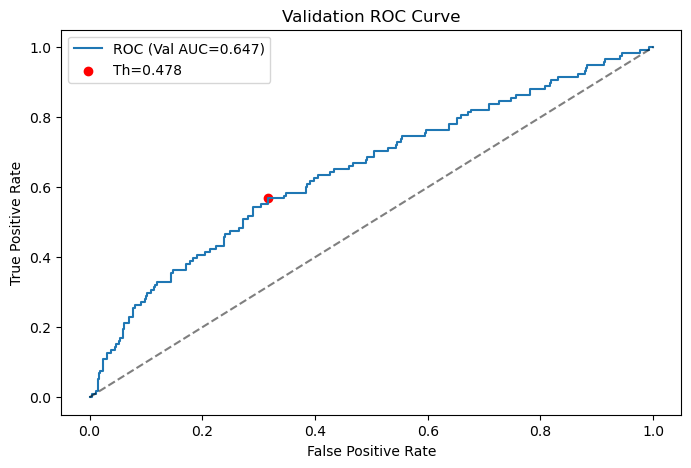

In [43]:
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC (Val AUC={auc_val:.3f})', color='#1f77b4')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
# Mark point closest to selected threshold on ROC
idx_thr_roc = np.argmin(np.abs(roc_thr - threshold_to_use))
plt.scatter(fpr[idx_thr_roc], tpr[idx_thr_roc], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()

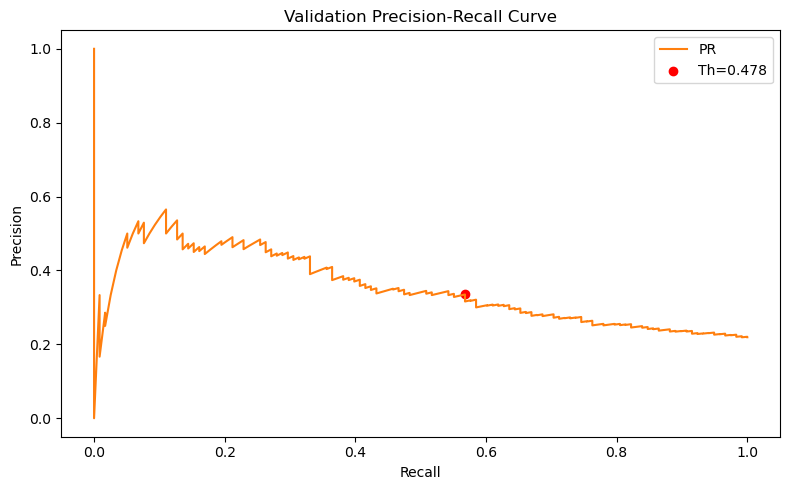

In [44]:
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label='PR', color='#ff7f0e')
# Mark point closest to selected threshold on PR
idx_thr_pr = np.argmin(np.abs(pr_thr - threshold_to_use))
idx_thr_pr = np.clip(idx_thr_pr, 0, len(precision)-1)
plt.scatter(recall[idx_thr_pr], precision[idx_thr_pr], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

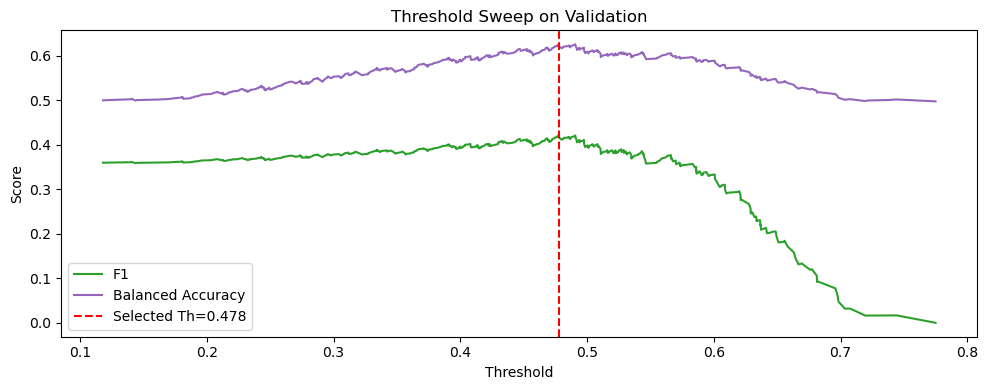

In [45]:
# Threshold vs F1 and Balanced Accuracy
plt.figure(figsize=(10,4))
plt.plot(thr_list, f1_list, label='F1', color='#2ca02c')
plt.plot(thr_list, bal_acc_list, label='Balanced Accuracy', color='#9467bd')
plt.axvline(threshold_to_use, color='red', linestyle='--', label=f'Selected Th={threshold_to_use:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep on Validation')
plt.legend()
plt.tight_layout()
plt.show()

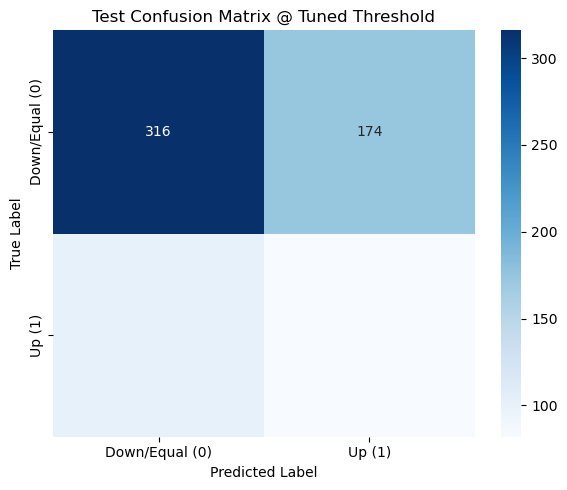

In [46]:

# Confusion Matrix Heatmap (Test @ tuned threshold)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down/Equal (0)', 'Up (1)'],
            yticklabels=['Down/Equal (0)', 'Up (1)'])
plt.title('Test Confusion Matrix @ Tuned Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loss')

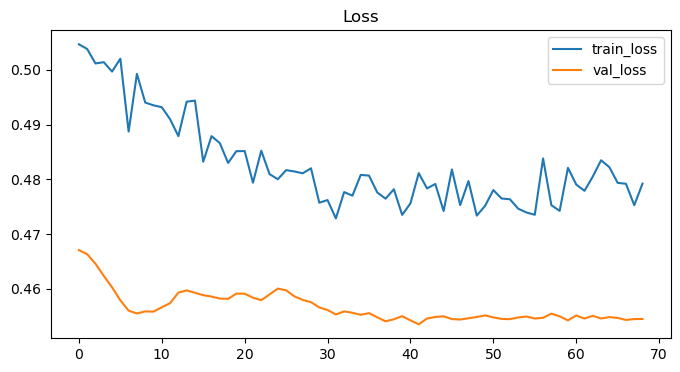

In [47]:
# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

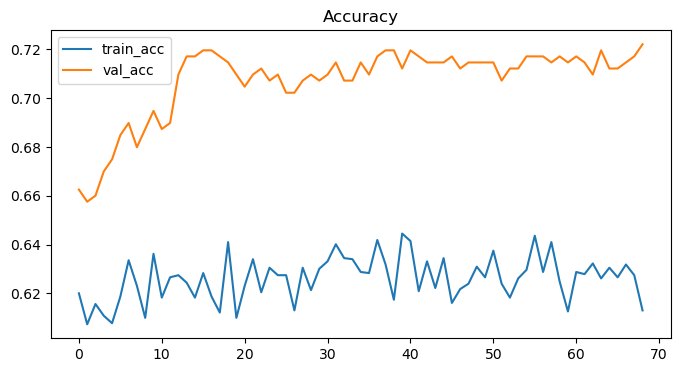

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [49]:
# Evaluate on test set (consistent tensors)
results = model.evaluate(X_test_3d, y_test, verbose=0)
print('\nLSTM Test Results:')
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')


LSTM Test Results:
  Loss: 0.4691
  Accuracy: 0.6077
  AUC: 0.5663
  Precision: 0.3151
  Recall: 0.3770
  F1-Score: 0.3433


In [50]:
# Save model (optional)
model.save('btc_dense_model.h5')
print('Saved model to btc_dense_model.h5')

Saved model to btc_dense_model.h5
